In [2]:
# Tratamiento de datos
# -----------------------------------------------------------------------
import pandas as pd
import numpy as np

# Visualizaciones
# -----------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import tree

# Para realizar la regresión lineal y la evaluación del modelo
# -----------------------------------------------------------------------
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold,LeaveOneOut, cross_val_score
from sklearn.model_selection import RandomizedSearchCV

# Agregar la carpeta 'src' al sys.path
import sys
import os
src_path = "../../src/"
sys.path.append(src_path)
import support_modeling as sp

# Ignorar los warnings
# -----------------------------------------------------------------------
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv("../../data/df_te.csv")
df.sample(5)

,Precio,Tipo de Propiedad,Exterior,Habitaciones,Baños,Provincia,Mostrar Dirección,Tiene Video,Tiene Plano,Tiene 360,Ascensor,Tamaño_robust,Distancia_robust
167,650.0,681.418301,681.494810,683.142537,685.558824,697.296774,680.507463,678.348548,677.895197,675.286765,684.527919,1.200000,0.691477
339,720.0,681.418301,681.494810,689.131332,685.558824,697.296774,680.507463,691.440441,677.895197,675.286765,679.870971,-0.033333,-0.006842
175,600.0,689.034696,681.494810,689.034696,685.558824,697.296774,688.751480,678.348548,677.895197,675.286765,684.527919,-0.900000,-0.309660
334,750.0,681.418301,681.494810,689.131332,685.558824,697.296774,680.507463,678.348548,677.895197,675.286765,684.527919,-0.366667,-0.288115
281,695.0,681.418301,686.923794,671.204570,685.558824,697.296774,680.507463,691.440441,691.007843,706.864550,684.527919,-0.033333,-0.337962


In [4]:
# Creacion de x (variables explicativas) e y (variable respuesta)
x=df.drop("Precio",axis=1)
y=df[["Precio"]]
x_train, x_test,y_train,y_test=train_test_split(x,y,train_size=0.8,random_state=42)

In [5]:
param_grid_rf = {
    'n_estimators': [100, 200, 300, 400], 
    'max_depth': [10, 15, 20, 25, None],       
    'min_samples_split': [2, 5, 10, 20],       
    'min_samples_leaf': [1, 2, 5, 10],         
    'max_features': ['sqrt', 'log2', None],    
}

# Configurar GridSearchCV para optimización exhaustiva
model_RandomForestRegressor = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid_rf,
    scoring='neg_mean_squared_error', 
    cv=10, 
    n_jobs=-1,  
    verbose=2  
)

# Entrenamiento del modelo
print("Iniciando búsqueda exhaustiva de hiperparámetros...")
model_RandomForestRegressor.fit(x_train, y_train)

Iniciando búsqueda exhaustiva de hiperparámetros...
Fitting 10 folds for each of 960 candidates, totalling 9600 fits


GridSearchCV(cv=10, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [10, 15, 20, 25, None],
                         'max_features': ['sqrt', 'log2', None],
                         'min_samples_leaf': [1, 2, 5, 10],
                         'min_samples_split': [2, 5, 10, 20],
                         'n_estimators': [100, 200, 300, 400]},
             scoring='neg_mean_squared_error', verbose=2)

In [6]:
y_test_pred_rf = model_RandomForestRegressor.predict(x_test)
y_train_pred_rf = model_RandomForestRegressor.predict(x_train)
sp.metricas(y_train, y_train_pred_rf, y_test, y_test_pred_rf)

,r2_score,MAE,MSE,RMSE,RMSE-MAE
Train,0.856800,21.751800,838.778500,28.961700,13.486100
Test,0.384900,40.556900,2920.647000,54.043000,13.486100
Diferenceia Train-Test,0.471900,-18.805100,-2081.868500,-25.081300,0.000000
Porcentaje diferencia (%),122.603300,-86.453100,-248.202400,-86.601600,0.000000
Media,683.535700,683.535700,683.535700,683.535700,683.535700
Ratio Media(%),0.090829,4.557823,274.998475,6.071717,1.972991
Influencia dif media (%),0.069000,2.751200,304.573500,3.669300,0.000000
Mediana,710.000000,710.000000,710.000000,710.000000,710.000000
Ratio Mediana(%),0.087444,4.387937,264.748275,5.845401,1.899451
Influencia dif mediana (%),0.066500,2.648600,293.220900,3.532600,0.000000


- El modelo tiene un buen desempeño en el entrenamiento, capturando gran parte de la variabilidad de los datos.
- Los errores son razonables en relación con la media y la mediana.
- Hay una gran brecha entre el entrenamiento y la prueba, lo que sugiere sobreajuste.
- El modelo podría beneficiarse de regularización adicional o de optimizar aún más los hiperparámetros.

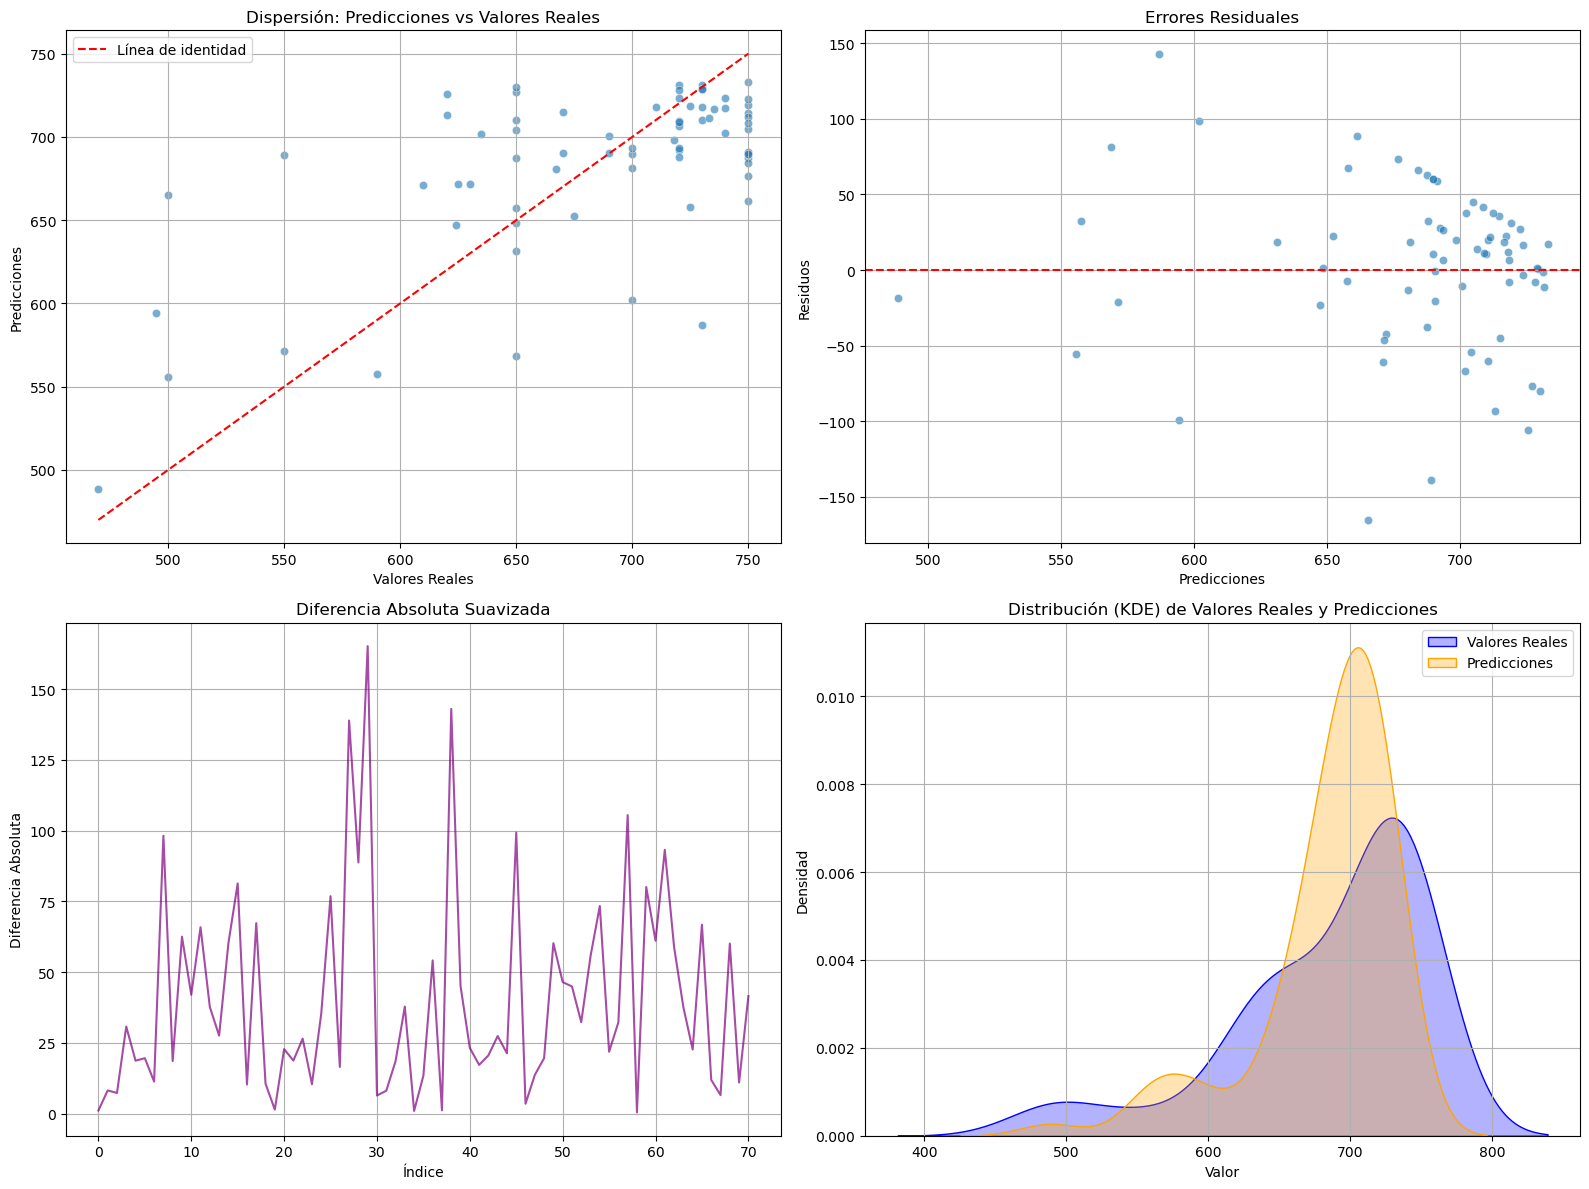

In [7]:
sp.comparativa_graficos(y_test, y_test_pred_rf)

### PROBAMOS A MEJORAR EL MODELO ELIMINANDO VARIABLES CON POCA REPERCUSIÓN

Calculamos la correlación de las variables con "Precio" para ver cuales pueden ser eliminadas por no ser representativas en el modelo

Correlaciones con 'Precio':
Precio               1.000000
Provincia            0.536239
Tiene 360            0.176591
Habitaciones         0.107024
Baños                0.105857
Tiene Plano          0.083271
Tiene Video          0.081027
Mostrar Dirección    0.046862
Tipo de Propiedad    0.036378
Ascensor             0.030791
Exterior             0.028026
Tamaño_robust       -0.076692
Distancia_robust    -0.516021
Name: Precio, dtype: float64


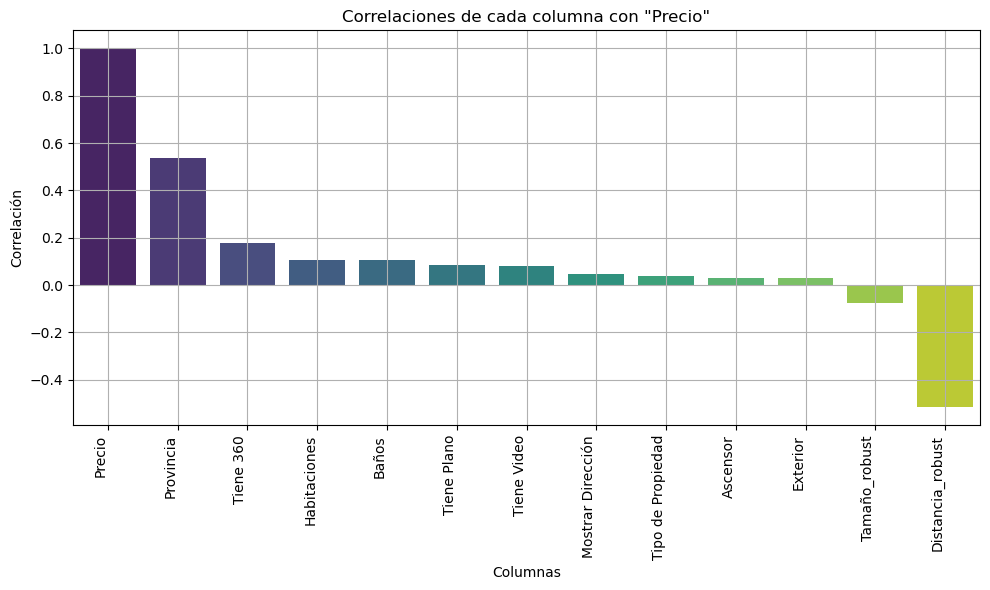


Columnas con baja correlación (abs < 0.05):
['Mostrar Dirección', 'Tipo de Propiedad', 'Ascensor', 'Exterior']


['Mostrar Dirección', 'Tipo de Propiedad', 'Ascensor', 'Exterior']

In [8]:
sp.analizar_correlaciones(df, "Precio", threshold=0.05)

In [9]:
# Excluir columnas irrelevantes según el análisis previo
columns_to_exclude = ['Mostrar Dirección', 'Tipo de Propiedad', 'Ascensor', 'Exterior']
df_filtered = df.drop(columns=columns_to_exclude)

In [10]:
# Definir las características (X) y la variable objetivo (y)
x2 = df_filtered.drop(columns=['Precio'])
y2 = df_filtered['Precio']

# Dividir los datos en conjuntos de entrenamiento y prueba
x_train2, x_test2, y_train2, y_test2 = train_test_split(x2, y2, test_size=0.2, random_state=42)

In [11]:
# Grid de Hiperparámetros
param_dist_rf = {
    'n_estimators': [100, 150],
    'max_depth': [15, 20, 25],
    'min_samples_split': [10, 20],
    'min_samples_leaf': [5, 10],
}

model_RandomForestRegressor2 = RandomizedSearchCV(
    RandomForestRegressor(random_state=42),
    param_distributions=param_dist_rf,
    n_iter=10, 
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    random_state=42
)
# Entrenamiento
model_RandomForestRegressor2.fit(x_train2, y_train2)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   n_jobs=-1,
                   param_distributions={'max_depth': [15, 20, 25],
                                        'min_samples_leaf': [5, 10],
                                        'min_samples_split': [10, 20],
                                        'n_estimators': [100, 150]},
                   random_state=42, scoring='neg_mean_squared_error')

In [12]:
y_test_pred_rf2 = model_RandomForestRegressor2.predict(x_test2)
y_train_pred_rf2 = model_RandomForestRegressor2.predict(x_train2)
sp.metricas(y_train2, y_train_pred_rf2, y_test2, y_test_pred_rf2)

,r2_score,MAE,MSE,RMSE,RMSE-MAE
Train,0.717400,30.347600,1655.668700,40.689900,13.025600
Test,0.403000,40.215300,2834.590200,53.240900,13.025600
Diferenceia Train-Test,0.314400,-9.867700,-1178.921500,-12.551000,0.000000
Porcentaje diferencia (%),78.014900,-32.515600,-71.205200,-30.845500,0.000000
Media,683.535700,683.535700,683.535700,683.535700,683.535700
Ratio Media(%),0.081956,5.161610,328.458258,6.870951,1.905621
Influencia dif media (%),0.046000,1.443600,172.474000,1.836200,0.000000
Mediana,710.000000,710.000000,710.000000,710.000000,710.000000
Ratio Mediana(%),0.078901,4.969218,316.215415,6.614845,1.834592
Influencia dif mediana (%),0.044300,1.389800,166.045300,1.767700,0.000000


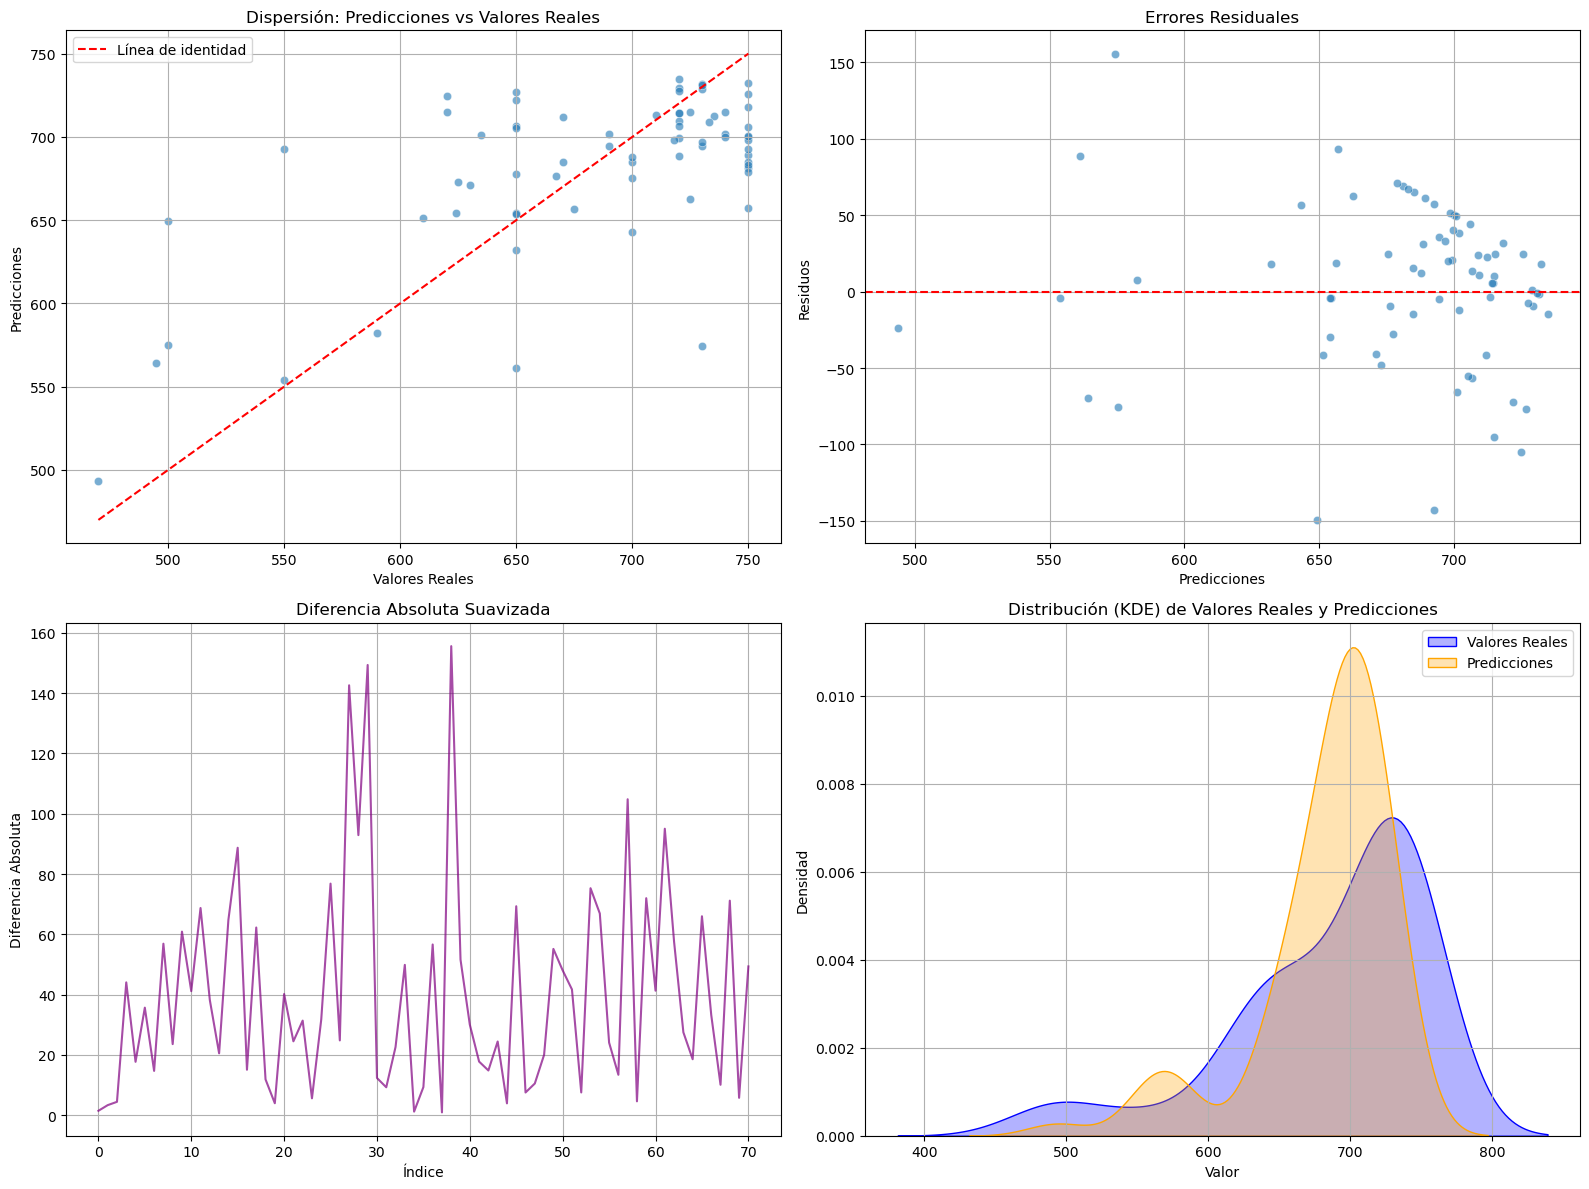

In [13]:
sp.comparativa_graficos( y_test2, y_test_pred_rf2)

#### COMPARATIVA DE METRICAS

In [14]:
sp.metricas(y_train, y_train_pred_rf, y_test, y_test_pred_rf)

,r2_score,MAE,MSE,RMSE,RMSE-MAE
Train,0.856800,21.751800,838.778500,28.961700,13.486100
Test,0.384900,40.556900,2920.647000,54.043000,13.486100
Diferenceia Train-Test,0.471900,-18.805100,-2081.868500,-25.081300,0.000000
Porcentaje diferencia (%),122.603300,-86.453100,-248.202400,-86.601600,0.000000
Media,683.535700,683.535700,683.535700,683.535700,683.535700
Ratio Media(%),0.090829,4.557823,274.998475,6.071717,1.972991
Influencia dif media (%),0.069000,2.751200,304.573500,3.669300,0.000000
Mediana,710.000000,710.000000,710.000000,710.000000,710.000000
Ratio Mediana(%),0.087444,4.387937,264.748275,5.845401,1.899451
Influencia dif mediana (%),0.066500,2.648600,293.220900,3.532600,0.000000


In [15]:
sp.metricas(y_train2, y_train_pred_rf2, y_test2, y_test_pred_rf2)

,r2_score,MAE,MSE,RMSE,RMSE-MAE
Train,0.717400,30.347600,1655.668700,40.689900,13.025600
Test,0.403000,40.215300,2834.590200,53.240900,13.025600
Diferenceia Train-Test,0.314400,-9.867700,-1178.921500,-12.551000,0.000000
Porcentaje diferencia (%),78.014900,-32.515600,-71.205200,-30.845500,0.000000
Media,683.535700,683.535700,683.535700,683.535700,683.535700
Ratio Media(%),0.081956,5.161610,328.458258,6.870951,1.905621
Influencia dif media (%),0.046000,1.443600,172.474000,1.836200,0.000000
Mediana,710.000000,710.000000,710.000000,710.000000,710.000000
Ratio Mediana(%),0.078901,4.969218,316.215415,6.614845,1.834592
Influencia dif mediana (%),0.044300,1.389800,166.045300,1.767700,0.000000


In [16]:
import pickle

# Guardar el modelo entrenado
with open('../../models/model_RandomForestRegressor2.pkl', 'wb') as file:
    pickle.dump(model_RandomForestRegressor2, file)